In [329]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Рекомендательная система для аниме

In [84]:
anime = pd.read_csv('./data/anime.csv')
rating = pd.read_csv('./data/rating.csv')

In [85]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [87]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Есть база пользователей и база объектов:

In [86]:
rating['user_id'].unique()

array([    1,     2,     3, ..., 73514, 73515, 73516], dtype=int64)

In [349]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4262566 entries, 47 to 7813736
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   anime_id     int64  
 2   rating       int64  
 3   mean_rating  float64
dtypes: float64(1), int64(3)
memory usage: 162.6 MB


Есть фидбек (у нас оценки пользователей):

In [130]:
rating['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

Задача - порекоммендовать пользователю что-то, что ему понравится:

In [152]:
#вырежем аниме, которым 500-ый человек в таблице поставил высшую оценку
user_500 = rating[rating['user_id'] == 500][rating['rating'] == 10]
name = []
ep = []
typ = []
genre = []
def best_for_500(what, where):
    for i in user_500['anime_id']:
        for j in anime[anime['anime_id'] == i][what]:
            where.append(j)
            
best_for_500('name', name)
best_for_500('episodes', ep)
best_for_500('type', typ)
best_for_500('genre', genre)

<ipython-input-152-fd80f48e616d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_500 = rating[rating['user_id'] == 500][rating['rating'] == 10]


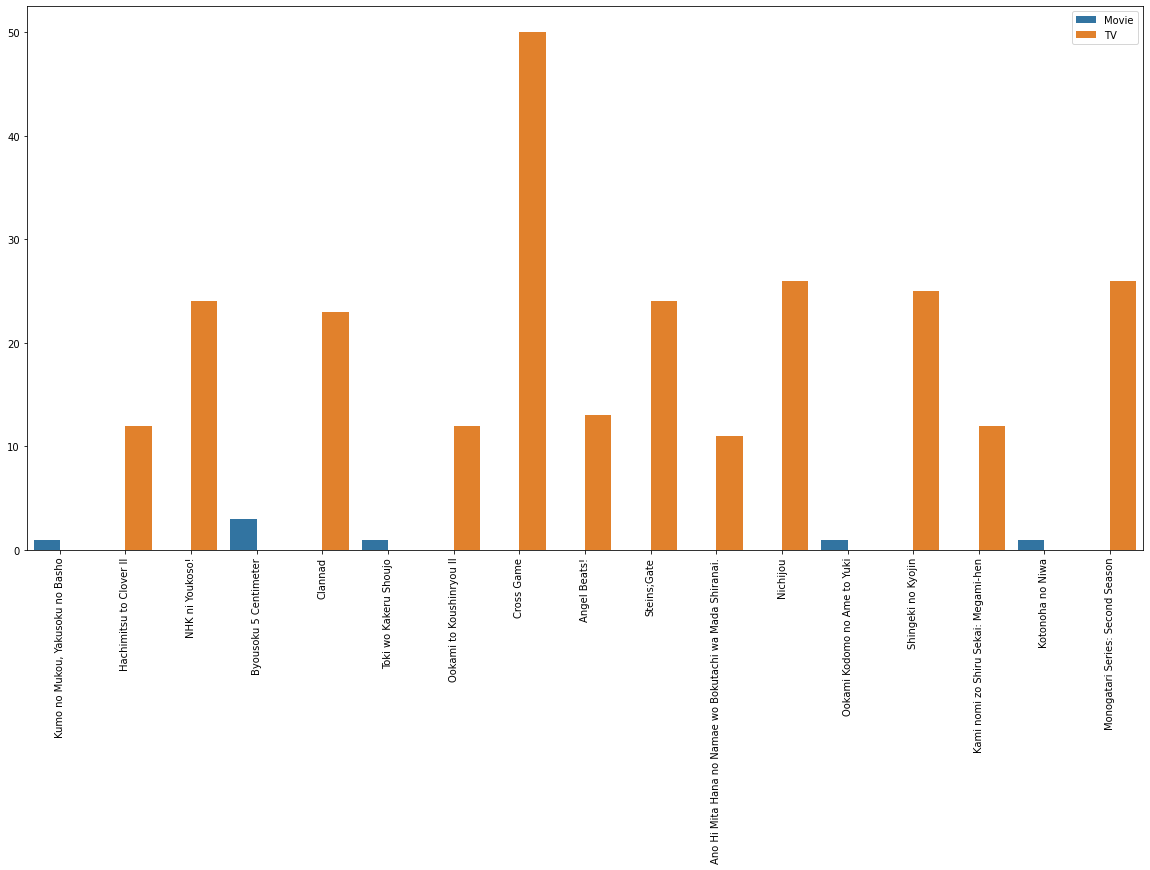

In [160]:
#в основном смотрит небольшие сериалы
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=name, y=list(map(lambda x: int(x), ep)), hue=typ)
for label in ax.get_xticklabels():
    label.set_rotation('vertical')

In [206]:
print(anime[anime['name'] == 'Ginga Eiyuu Densetsu'].rating)
print(rating[rating['anime_id'] == 820].rating.mean())

7    9.11
Name: rating, dtype: float64
9.059627329192546


In [211]:
# средний рейтинг аниме выводился на основе каких-то других данных, тк он отличается от среднего по пользователям в датасете
print(anime[anime['name'] == 'Serial Experiments Lain'].rating)
print(rating[rating['anime_id'] == 339].rating.mean())

540    7.99
Name: rating, dtype: float64
8.061640346408558


In [223]:
popular = anime[anime['rating'] >= 9]
popular.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [222]:
def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [289]:
tags = []
for i in popular['genre']:
    tags.extend(re.findall(r'\w+', i))
occur = {}
i = 0
#for i in tags:
#    if i is in occur.values():    

## Выбор модели

### 1. Кластеризация пользователей: 

https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation 
1. Поработал с лайками, решил, что лайком будет считаться rating mean, не превосходящий rating от оценки сериала.

In [165]:
rating[rating['user_id']==1]['rating'].mean()

-0.7124183006535948

In [169]:
MRPU = rating.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']
MRPU.drop(['anime_id','rating'],axis=1, inplace=True)

In [170]:
MRPU.head()

,user_id,mean_rating
0,1,-0.712418
1,2,2.666667
2,3,7.382979
3,4,-1.000000
4,5,4.263383


In [180]:
# мердж с рейтингом, чтобы был айди сериала
rating = pd.merge(rating,MRPU,on=['user_id','user_id'])
rating.head(5)

,user_id,anime_id,rating,mean_rating
0,1,20,-1,-0.712418
1,1,24,-1,-0.712418
2,1,79,-1,-0.712418
3,1,226,-1,-0.712418
4,1,241,-1,-0.712418


In [182]:
rating = rating.drop(rating[rating.rating < rating.mean_rating].index)
rating.head()

,user_id,anime_id,rating,mean_rating
47,1,8074,10,-0.712418
81,1,11617,10,-0.712418
83,1,11757,10,-0.712418
101,1,15451,10,-0.712418
153,2,11771,10,2.666667


Пользователь имеет тенденцию оценивать на 5, если оценил что-то на 4, то оно ему не понравилось. Кажется, подход хорош тем, что учитывает не какой-то порог - "всё что больше 7 - лайк".

In [185]:
rating[rating['user_id']== 1]

,user_id,anime_id,rating,mean_rating
47,1,8074,10,-0.712418
81,1,11617,10,-0.712418
83,1,11757,10,-0.712418
101,1,15451,10,-0.712418


In [184]:
for i in rating[rating['user_id']== 1]['anime_id']:
    for j in anime[anime['anime_id'] == i]['name']:
        print(j)

Highschool of the Dead
High School DxD
Sword Art Online
High School DxD New


In [186]:
rating[rating['user_id']== 400]

,user_id,anime_id,rating,mean_rating
36580,400,19,9,6.573099
36581,400,20,8,6.573099
36582,400,24,8,6.573099
36583,400,30,7,6.573099
36584,400,31,7,6.573099
...,...,...,...,...
36746,400,28977,9,6.573099
36747,400,30276,10,6.573099
36748,400,31181,8,6.573099
36749,400,31240,8,6.573099


In [196]:
#надо собрать два датасета, выбрать какую-то небольшую часть данных, чтобы времени меньше занимал
mergedata = pd.merge(anime,rating,on=['anime_id','anime_id'])
mergedata = mergedata[mergedata.user_id <= 20000]
mergedata = mergedata.rename({'rating_y':'userRating', 'rating_x':'rating'}, axis='columns')
mergedata.head()

,anime_id,name,genre,type,episodes,rating,members,user_id,userRating,mean_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,7.699301
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,8.729242
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,7.372287
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10,8.356322
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10,-0.832298
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8,7.374593
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490,10,8.062500
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548,10,8.112360
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,570,10,8.388889
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,598,10,8.680328


Что происходит в новом датасете: там лежат "лайки" - средняя оценка пользователя vs оценка

Где: rating - средняя по аниме; userRating - уникальная для пользователя; mean_rating - средняя по пользователю

In [197]:
mergedata.shape

(1131696, 10)

In [199]:
len(mergedata['anime_id'].unique())

7852

2. Посмотрим теперь поближе на сериалы, которые понравились конкретному пользователю.

In [200]:
user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])
user_anime.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,...,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
user_anime[user_anime['Serial Experiments Lain'] == 1]

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,...,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### PCA

In [318]:
pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

In [319]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,-1.579129,-0.500240,0.415766
1,-1.773553,-0.272593,0.116391
2,0.218814,-1.232282,-0.985814
3,0.199435,-0.291005,0.681024
4,3.532125,-0.184796,-0.743321


In [322]:
print(f'Было {user_anime.shape}, стало {ps.shape}')

Было (20000, 7852), стало (20000, 3)


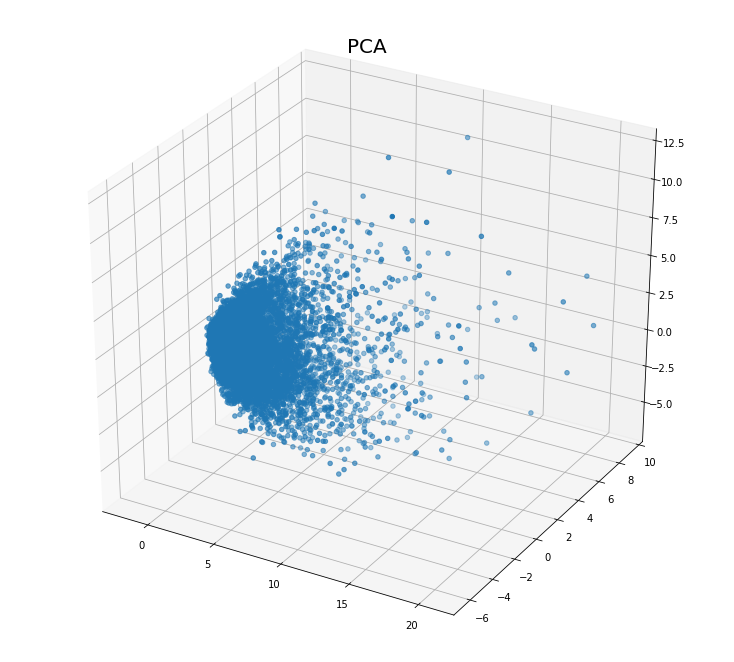

In [328]:
tocluster = pd.DataFrame(ps[[0,1,2]])
plt.rcParams['figure.figsize'] = (10, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('PCA', fontsize=20)
plt.show()

### K-Means

In [352]:
clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)
print(c_preds)

[[-1.09956788 -0.03848558  0.06957675]
 [ 7.39921431 -0.702936    0.7606988 ]
 [ 1.89354819 -1.09380406 -0.44076007]
 [ 1.65006305  2.31954213 -0.01746228]]
[0 0 2 ... 0 2 0]


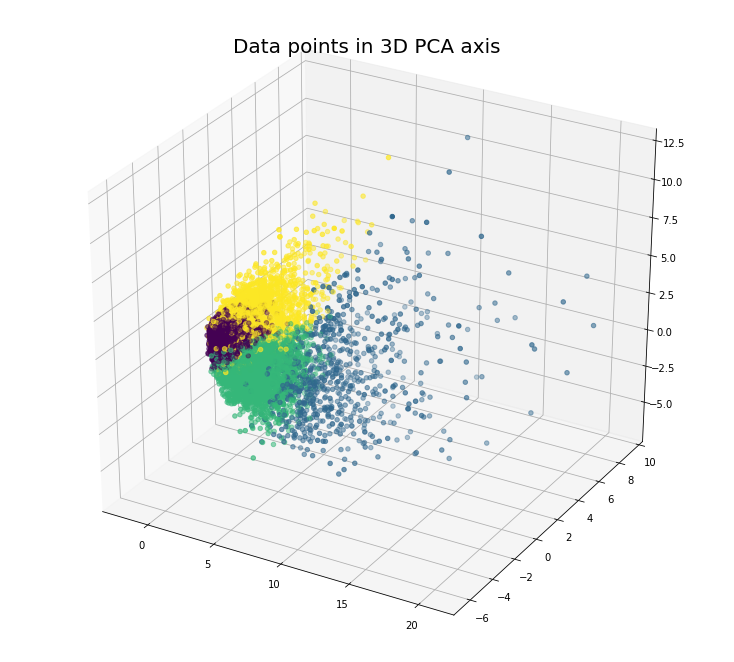

In [331]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

In [337]:
user_anime['cluster'] = c_preds
user_anime['cluster']

user_id
1        0
2        0
3        2
4        0
5        2
        ..
19996    0
19997    0
19998    0
19999    2
20000    0
Name: cluster, Length: 20000, dtype: int32

### Что всё это значит?

In [338]:
# для каждого из 4 кластеров считаем среднее по колонкам и сохраняем в переменные
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()

In [343]:
c0.sort_values(ascending=False)[0:15]

name
Death Note                            0.319035
Shingeki no Kyojin                    0.227831
Sword Art Online                      0.196996
Fullmetal Alchemist: Brotherhood      0.179737
Code Geass: Hangyaku no Lelouch       0.177426
Sen to Chihiro no Kamikakushi         0.159012
Angel Beats!                          0.155763
Fullmetal Alchemist                   0.155329
Code Geass: Hangyaku no Lelouch R2    0.151935
Naruto                                0.145075
Elfen Lied                            0.143703
Ouran Koukou Host Club                0.133304
Mirai Nikki (TV)                      0.120017
Toradora!                             0.116190
Howl no Ugoku Shiro                   0.114096
dtype: float64

In [344]:
c1.sort_values(ascending=False)[0:15]

name
predicted                                              1.000000
Angel Beats!                                           0.828571
No Game No Life                                        0.821769
Toradora!                                              0.809524
Steins;Gate                                            0.793197
Code Geass: Hangyaku no Lelouch                        0.789116
Shingeki no Kyojin                                     0.783673
Sword Art Online                                       0.764626
Code Geass: Hangyaku no Lelouch R2                     0.763265
Death Note                                             0.746939
Bakemonogatari                                         0.745578
Fullmetal Alchemist: Brotherhood                       0.731973
Hataraku Maou-sama!                                    0.727891
Mirai Nikki (TV)                                       0.725170
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.714286
dtype: float64

In [345]:
c2.sort_values(ascending=False)[0:15]

name
predicted                             2.000000
Shingeki no Kyojin                    0.721744
No Game No Life                       0.633343
Sword Art Online                      0.608425
Death Note                            0.589439
Angel Beats!                          0.589143
Steins;Gate                           0.544646
Fullmetal Alchemist: Brotherhood      0.535449
Toradora!                             0.509938
Mirai Nikki (TV)                      0.504005
Code Geass: Hangyaku no Lelouch       0.501335
Code Geass: Hangyaku no Lelouch R2    0.473450
One Punch Man                         0.457728
Noragami                              0.457134
Tokyo Ghoul                           0.454168
dtype: float64

In [346]:
c3.sort_values(ascending=False)[0:15]

name
predicted                             3.000000
Death Note                            0.679863
Code Geass: Hangyaku no Lelouch       0.667644
Code Geass: Hangyaku no Lelouch R2    0.609482
Fullmetal Alchemist                   0.601173
Sen to Chihiro no Kamikakushi         0.583089
Suzumiya Haruhi no Yuuutsu            0.549853
Neon Genesis Evangelion               0.538612
Tengen Toppa Gurren Lagann            0.529814
Cowboy Bebop                          0.525415
Fullmetal Alchemist: Brotherhood      0.506843
Mononoke Hime                         0.499022
Toradora!                             0.487292
Elfen Lied                            0.480938
Howl no Ugoku Shiro                   0.477517
dtype: float64

И дальше можно смотреть еще какие жанры входят...

Итак, мы берем пользователя и аниме, которым он поставил лайки, потом кластеризуем пользователей с их лайками. Как можем порекомендовать - смотрим, в каком кластере пользователь по интересам, находим в кластере по какому-то принципу аниме, которое он не смотрел, рекомендуем.